## Importing necessary libraries

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import copy

### Function to load the image from a file path

In [2]:
def load_image(image_path):
    image = Image.open(image_path)
    return np.array(image)

### Function to check if a pixel is white

In [3]:
def is_white(pixel):
    # For a grayscale image, a white pixel would have a value close to 255
    return pixel >= 200

### Function to prompt user for file path

In [4]:
def get_image_path():
    return input("Enter the file path of the image: ")


## Function to read and show the image from the locally downloaded file

In [5]:
def read_image():
    image_path = get_image_path()
    image_data = load_image(image_path)
    
    # Show the imported image
    plt.imshow(image_data, cmap='gray')
    plt.title('Imported Image')
    plt.axis('off')
    plt.show()

    # Convert to grayscale if it's a color image
    if len(image_data.shape) == 3:
        image_data = np.mean(image_data, axis=2).astype(np.uint8)

    # Resize the image to 64x64 if it's not already that size
    image_data = np.array(Image.fromarray(image_data).resize((64, 64)))
    
    return image_data

## Create a 64x64 binary matrix to represent white points

In [6]:
def create_binary_matrix(image_data):
    binary_matrix = np.zeros((64, 64), dtype=int)

    # Iterate through the image data and set the binary matrix
    for i in range(64):
        for j in range(64):
            if is_white(image_data[i, j]):
                binary_matrix[i, j] = 1
    
    return binary_matrix

## Create a dataframe of white points for plotting

Enter the file path of the image:  C:\Users\shaur\AppData\Local\Temp\e2099ebb-224c-41ad-b096-a36f3ec68df0_drive-download-20240515T222139Z-001.zip.df0\1.png


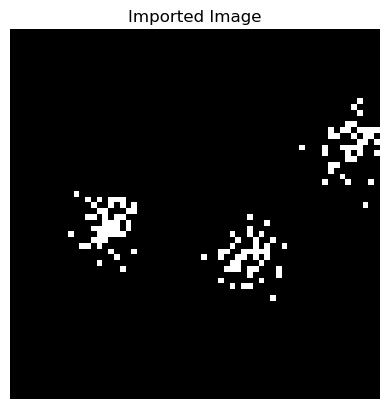

In [7]:
image_data = read_image()

white_points = np.argwhere(create_binary_matrix(image_data) == 1)
df = pd.DataFrame(white_points, columns=['x', 'y'])

# Function to run k-means with elbow method

In [8]:
def run_kmeans_with_elbow(data, max_k, image_width, image_height, num_runs, colmap):
    elbow_points = []
    for k in range(1, max_k + 1):
        centroids, df = run_kmeans_multiple_times(data, k, image_width, image_height, num_runs, colmap)
        elbow_points.append((k, calculate_total_variation(df, centroids)))
    return elbow_points

# Function to plot the elbow graph and get user input for k

In [9]:
def plot_elbow_graph(elbow_points):
    ks, variations = zip(*elbow_points)
    plt.plot(ks, variations, marker='o')
    plt.title('Elbow Method for Optimal K')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Total Variation')
    plt.grid(True)
    plt.show()

# Function to run k-means multiple times and select the best clusters

In [10]:
def run_kmeans_multiple_times(data, k, image_width, image_height, num_runs, colmap):
    lowest_variation = float('inf')
    best_centroids = None
    best_df = None
    for _ in range(num_runs):
        centroids = generate_centroids(k, image_width, image_height)
        df = assignment(data, centroids, colmap)
        while True:
            closest_centroids = df['closest'].copy(deep=True)
            centroids = update(centroids, df)
            df = assignment(data, centroids, colmap)
            if closest_centroids.equals(df['closest']):
                break
        total_variation = calculate_total_variation(df, centroids)
        if total_variation < lowest_variation:
            lowest_variation = total_variation
            best_centroids = copy.deepcopy(centroids)
            best_df = df.copy(deep=True)
    return best_centroids, best_df

## Function to generate random centroids

In [11]:
def generate_centroids(k, image_width, image_height):
    centroids = {}
    for i in range(1, k + 1):
        x = np.random.randint(0, image_width)
        y = np.random.randint(0, image_height)
        centroids[i] = [x, y]
    return centroids


# Function to assign points to centroids

In [12]:
def assignment(data, centroids, colmap):
    centroid_distance_cols = [f'distance_from_{i}' for i in centroids.keys()]
    for i in centroids.keys():
        data[f'distance_from_{i}'] = (
            np.sqrt((data['x'] - centroids[i][0]) ** 2 + (data['y'] - centroids[i][1]) ** 2)
        )
    data['closest'] = data.loc[:, centroid_distance_cols].idxmin(axis=1)
    data['closest'] = data['closest'].map(lambda x: int(x.lstrip('distance_from_')))
    data['color'] = data['closest'].map(lambda x: colmap[x])
    return data

# Function to update centroids

In [13]:
def update(centroids, data):
    for i in centroids.keys():
        centroids[i][0] = np.mean(data[data['closest'] == i]['x'])
        centroids[i][1] = np.mean(data[data['closest'] == i]['y'])
    return centroids

# Function to calculate total variation

In [14]:
def calculate_total_variation(data, centroids):
    total_variation = 0
    for i in centroids.keys():
        total_variation += np.sum(
            np.sqrt((data[data['closest'] == i]['x'] - centroids[i][0]) ** 2 +
                    (data[data['closest'] == i]['y'] - centroids[i][1]) ** 2)
        )
    return total_variation

### Define a color map for each cluster

In [15]:
colmap = {1: 'red', 2: 'blue', 3: 'green', 4: 'orange', 5: 'purple', 6: 'brown', 7: 'pink', 8: 'gray', 9: 'cyan', 10: 'magenta'}

# Function to detect the elbow point

In [16]:
def detect_elbow_point(elbow_points):
    ks, variations = zip(*elbow_points)
    ks = np.array(ks)
    variations = np.array(variations)
    
    # Calculating the second derivative of the variations
    first_derivative = np.diff(variations)
    second_derivative = np.diff(first_derivative)
    
    # Finding the index of the maximum change in the second derivative
    elbow_index = np.argmax(second_derivative) + 1  # +1 to correct the index after np.diff
    
    return ks[elbow_index]

## Code using above functions for elbow point graph plot and optimal k 

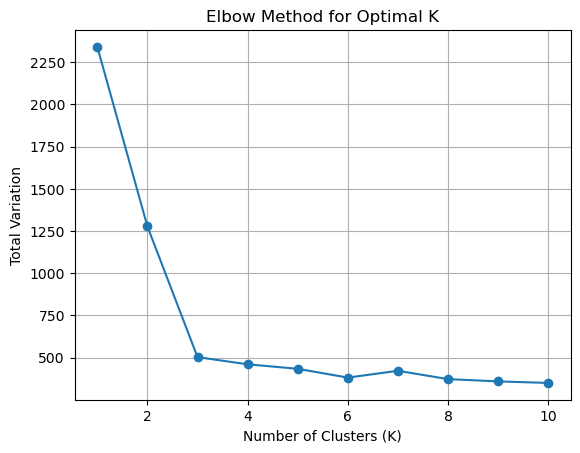

Optimal K detected from graph: 3


In [17]:
# Running k-means with elbow method
max_k = 10
num_runs = 10
elbow_points = run_kmeans_with_elbow(df, max_k, 64, 64, num_runs, colmap)

# Plotting the elbow graph
plot_elbow_graph(elbow_points)

# Detecting the optimal k using the elbow method
k = detect_elbow_point(elbow_points)
print(f"Optimal K detected from graph: {k}")

## Code using functions above for final cities plot

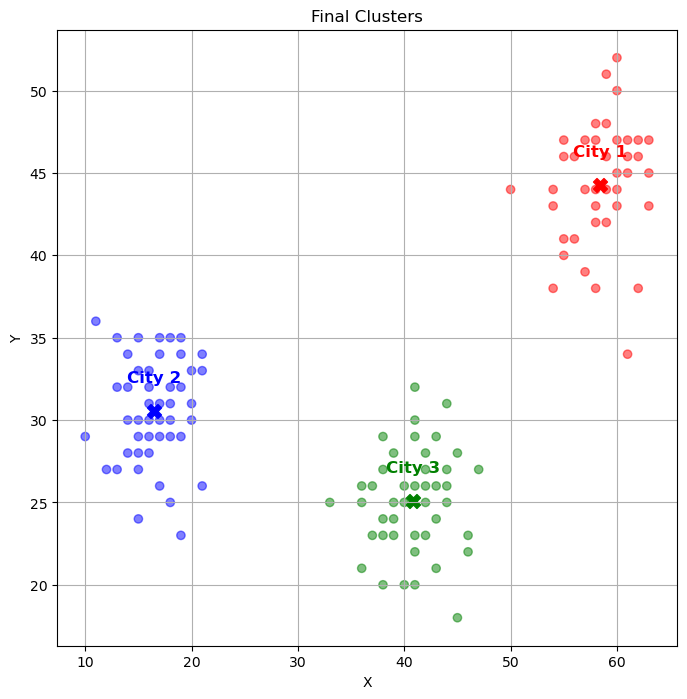

In [18]:
# Running k-means 
best_centroids, best_df = run_kmeans_multiple_times(df, k, 64, 64, 10, colmap)

# Defining city names for clusters
city_names = {i: f'City {i}' for i in best_centroids.keys()}

image_width = 64
image_height = 64

best_df['x_rot'] = best_df['y']
best_df['y_rot'] = image_width - best_df['x']

for i in best_centroids.keys():
    best_centroids[i] = [best_centroids[i][1], image_width - best_centroids[i][0]]

# Plotting cities
plt.figure(figsize=(8, 8))
plt.scatter(best_df['x_rot'], best_df['y_rot'], color=best_df['color'], alpha=0.5)
for i in best_centroids.keys():
    plt.scatter(*best_centroids[i], color=colmap[i], marker='X', s=100)
    plt.text(best_centroids[i][0], best_centroids[i][1] + 2, city_names[i],  # Adjusted position
             fontsize=12, fontweight='bold', color=colmap[i], ha='center', va='center')
plt.title('Final Clusters')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()

# Printing table showing distances between the cities

In [19]:
# Calculating distances between centroids
distances = []
for i in best_centroids.keys():
    for j in best_centroids.keys():
        if i < j:
            distance = np.sqrt((best_centroids[i][0] - best_centroids[j][0]) ** 2 +
                               (best_centroids[i][1] - best_centroids[j][1]) ** 2)
            distances.append((f"{city_names[i]} and {city_names[j]}", distance))

# Creating a DataFrame for the distances
distance_df = pd.DataFrame(distances, columns=['Cities', 'Distance'])

# Printing the distances table
def print_table_with_borders(df):
    col_widths = [max(len(str(cell)) for cell in df[col].values) for col in df.columns]
    col_widths = [max(len(col_name), col_width) for col_name, col_width in zip(df.columns, col_widths)]
    
    def print_separator():
        print("+" + "+".join(["-" * (width + 2) for width in col_widths]) + "+")
    
    def print_row(row):
        print("| " + " | ".join([f"{str(cell):{width}}" for cell, width in zip(row, col_widths)]) + " |")
    
    print_separator()
    print_row(df.columns)
    print_separator()
    for index, row in df.iterrows():
        print_row(row)
    print_separator()

print("\nDistances between cities (centroids):")
print_table_with_borders(distance_df)


Distances between cities (centroids):
+-------------------+--------------------+
| Cities            | Distance           |
+-------------------+--------------------+
| City 1 and City 2 | 44.158775128406916 |
| City 1 and City 3 | 26.07586630343949  |
| City 2 and City 3 | 24.969670633907217 |
+-------------------+--------------------+
